# Tests coherence results CG with polarization only

In [1]:
import sys, os, time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
from matplotlib.colors import LogNorm, SymLogNorm

In [2]:
import micmac as blindcp
sys.path.append("/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/Pixel-Non-Parametric-CompSep/test_playground/")
from func_tools_for_tests import *


In [3]:
nside = 64
lmax = nside*2
lmin = 2

nstokes = 2
number_correlations = 4
max_number_correlations = 6

jump_iter_samples = 1
n_iter = 8

In [4]:
noise_level = 10**(-7)

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes}
param_dict["number_correlations"] = number_correlations

In [5]:
camb_cls = generate_power_spectra_CAMB(max(lmax,nside*2))[:lmax+1,:]
CMB_map_input = hp.synfast(camb_cls.T, nside, new=True, lmax=lmax)

c_ells_noise_2 = np.zeros((max_number_correlations, lmax+1))
c_ells_noise_2[:3,2:] = noise_level

map_wn_2 = hp.synfast(c_ells_noise_2, nside, new=True, lmax=lmax)
map_total = CMB_map_input + map_wn_2

c_ells_input = np.zeros((6, lmax+1))
ell_arange_lmin = np.arange(lmin, lmax+1)
c_ells_input[:2,lmin:] = 10**(-4)/(ell_arange_lmin*(ell_arange_lmin+1))
c_ells_input[2,lmin:] = 10**(-6)/(ell_arange_lmin*(ell_arange_lmin+1))
c_ells_input[:3,:lmin] = 10**(-30)

if nstokes == 2:
    indices_polar = np.array([1,2,4])
    c_ells_noise_2 = c_ells_noise_2[indices_polar,:]
    c_ells_input = c_ells_input[indices_polar,:]
    CMB_map_input = CMB_map_input[1:,:]
    map_total = map_total[1:,:]


Calculating spectra from CAMB !


In [6]:
c_ells_input[:,2]

array([1.66666667e-05, 1.66666667e-07, 0.00000000e+00])

In [7]:
red_inverse_noise = blindcp.get_inverse_reduced_matrix_from_c_ell(c_ells_noise_2, lmin=lmin)
c_ell_sampled = np.copy(c_ells_input)

red_covariance_matrix = blindcp.get_reduced_matrix_from_c_ell(c_ell_sampled)[lmin:,...]

# Getting analytical + theoretical c_ells

In [8]:
unit_variance_maps = 1/hp.nside2resol(nside)
map_white_noise_xi = np.random.normal(loc=0, scale=unit_variance_maps, size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_white_noise_chi = np.random.normal(loc=0, scale=unit_variance_maps, size=(param_dict["nstokes"],12*param_dict["nside"]**2))

In [9]:
red_inverse_covariance = np.linalg.pinv(red_covariance_matrix)
analytical_WF_0, analytical_WF_1 = get_all_analytical_fluctuating_term_maps_v2(param_dict, red_inverse_covariance, red_inverse_noise, map_white_noise_xi, map_white_noise_chi, lmin=lmin, n_iter=n_iter)
analytical_WF_0b, analytical_WF_1b = get_all_analytical_fluctuating_term_maps_v3sqrt(param_dict, red_inverse_covariance, red_inverse_noise, map_white_noise_xi, map_white_noise_chi, lmin=lmin, n_iter=n_iter)


Exact-Python-0 Fluct sqrt exact computed for fluctuating term !!
Exact-Python-0 Fluct sqrt exact computed for fluctuating term !!


In [10]:
red_inverse_covariance_sqrt = blindcp.get_sqrt_reduced_matrix_from_matrix(red_inverse_covariance)
red_inverse_noise_sqrt = blindcp.get_sqrt_reduced_matrix_from_matrix(red_inverse_noise)
right_member_0_a = blindcp.maps_x_reduced_matrix_generalized_sqrt_sqrt(map_white_noise_xi.reshape((param_dict["nstokes"],12*param_dict["nside"]**2)), red_inverse_covariance_sqrt, lmin=lmin, n_iter=n_iter)
right_member_0_b = blindcp.maps_x_reduced_matrix_generalized_sqrt_sqrt(map_white_noise_chi.reshape((param_dict["nstokes"],12*param_dict["nside"]**2)), red_inverse_noise_sqrt, lmin=lmin, n_iter=n_iter)
right_member_0b_a = blindcp.maps_x_reduced_matrix_generalized_sqrt(map_white_noise_xi.reshape((param_dict["nstokes"],12*param_dict["nside"]**2)), red_inverse_covariance_sqrt, lmin=lmin, n_iter=n_iter)
right_member_0b_b = blindcp.maps_x_reduced_matrix_generalized_sqrt(map_white_noise_chi.reshape((param_dict["nstokes"],12*param_dict["nside"]**2)), red_inverse_noise_sqrt, lmin=lmin, n_iter=n_iter)

full_proper_right_hand_side = right_member_0_a + right_member_0_b
full_proper_right_hand_side_b = right_member_0b_a + right_member_0b_b
map_zero = np.zeros_like(full_proper_right_hand_side[0])
c_ell_proper_RHS = hp.anafast(np.vstack([map_zero, full_proper_right_hand_side]), lmax=lmax, iter=n_iter)[indices_polar]
c_ell_proper_RHS_b = hp.anafast(np.vstack([map_zero, full_proper_right_hand_side_b]), lmax=lmax, iter=n_iter)[indices_polar]

In [11]:
red_inverse_covariance_sqrt[2,...], red_inverse_noise_sqrt[2,...]

(array([[ 447.2135955,    0.       ],
        [   0.       , 4472.135955 ]]),
 array([[3162.27766017,    0.        ],
        [   0.        , 3162.27766017]]))

In [12]:
map_fluctuation_1 = personnalized_synfast(param_dict, red_inverse_covariance_sqrt, random_map=map_white_noise_xi, lmin=lmin, n_iter=n_iter)
map_fluctuation_2 = personnalized_synfast(param_dict, red_inverse_noise_sqrt, random_map=map_white_noise_chi, lmin=lmin, n_iter=n_iter)

map_fluctuation_1_hp = hp_synfast(param_dict, red_inverse_covariance_sqrt, lmin=lmin, n_iter=n_iter)
map_fluctuation_2_hp = hp_synfast(param_dict, red_inverse_noise_sqrt, lmin=lmin, n_iter=n_iter)

c_ell_fluctuation_1 = hp.anafast(np.vstack([map_zero, map_fluctuation_1]), lmax=lmax, iter=n_iter)[indices_polar]
c_ell_fluctuation_2 = hp.anafast(np.vstack([map_zero, map_fluctuation_2]), lmax=lmax, iter=n_iter)[indices_polar]

c_ell_fluctuation_1_hp = hp.anafast(map_fluctuation_1_hp, lmax=lmax, iter=n_iter)[indices_polar]
c_ell_fluctuation_2_hp = hp.anafast(map_fluctuation_2_hp, lmax=lmax, iter=n_iter)[indices_polar]

c_ell_inv_cov_sqrt = blindcp.get_c_ells_from_red_covariance_matrix(red_inverse_covariance_sqrt)
c_ell_inv_noise_sqrt = blindcp.get_c_ells_from_red_covariance_matrix(red_inverse_noise_sqrt)

In [13]:
variance_fluct = np.linalg.pinv(np.linalg.pinv(red_covariance_matrix) + red_inverse_noise)
real_fluctuation_variance = blindcp.get_c_ells_from_red_covariance_matrix(variance_fluct)
# real_fluctuation_variance_b = np.power(blindcp.get_c_ells_from_red_covariance_matrix(variance_fluct),2)

inv_variance_fluct = np.linalg.pinv(red_covariance_matrix) + red_inverse_noise
true_inv_fluctuation_variance = blindcp.get_c_ells_from_red_covariance_matrix(inv_variance_fluct)


# Graphs

In [14]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)


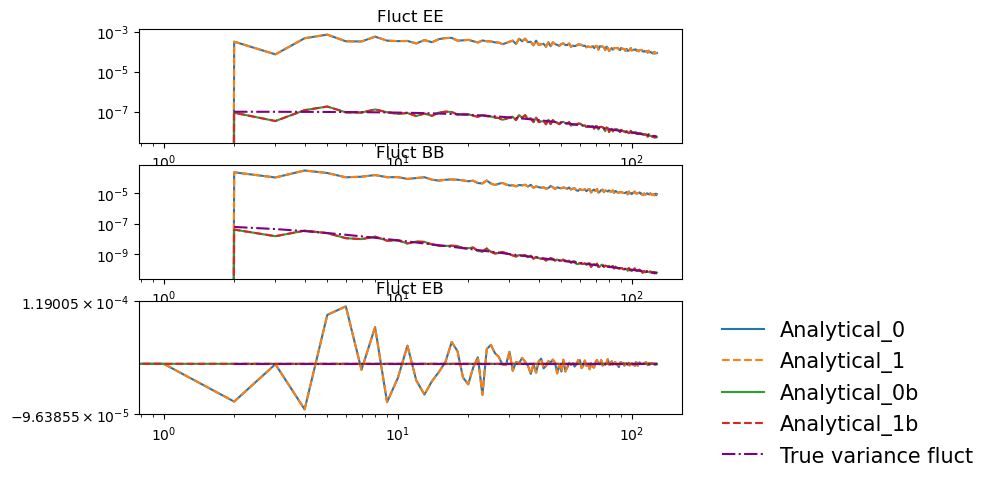

In [15]:
list_correl = ['EE', 'BB', 'EB']
indices_polar = np.array([1,2,4])

plt.figure(figsize=(7,5))
# plt.suptitle("Iter {} for mask {} with noise level {}".format(i, mask_name, noise_level), y=0.91)
plt.suptitle("")


# c_ells_output = hp.anafast(maps_iter, lmax=lmax, iter=n_iter)[indices_polar]
map_zeros = np.zeros_like(analytical_WF_0[0])
c_ells_analytical_fluct_0 = hp.anafast(np.vstack([map_zeros, analytical_WF_0]), lmax=lmax, iter=n_iter)[indices_polar]
c_ells_analytical_fluct_1 = hp.anafast(np.vstack([map_zeros, analytical_WF_1]), lmax=lmax, iter=n_iter)[indices_polar]

c_ells_analytical_fluct_0b = hp.anafast(np.vstack([map_zeros, analytical_WF_0b]), lmax=lmax, iter=n_iter)[indices_polar]
c_ells_analytical_fluct_1b = hp.anafast(np.vstack([map_zeros, analytical_WF_1b]), lmax=lmax, iter=n_iter)[indices_polar]

ell_arange = np.arange(c_ells_analytical_fluct_0b.shape[1])
for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title('Fluct '+list_correl[j])

    # plt.plot(ell_arange, c_ells_total.T[:,indices_polar[j]], label='Input')
    plt.plot(ell_arange, c_ells_analytical_fluct_0[j], label='Analytical_0')
    plt.plot(ell_arange, c_ells_analytical_fluct_1[j], '--', label='Analytical_1')
    
    plt.plot(ell_arange, c_ells_analytical_fluct_0b[j], label='Analytical_0b')
    plt.plot(ell_arange, c_ells_analytical_fluct_1b[j], '--', label='Analytical_1b')

    # plt.plot(ell_arange, c_ells_CG_fluct_0[j], '-.', label='CG')

    plt.plot(ell_arange[lmin:], real_fluctuation_variance[j], '-.', color="purple", label='True variance fluct')

    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')

    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


plt.show()

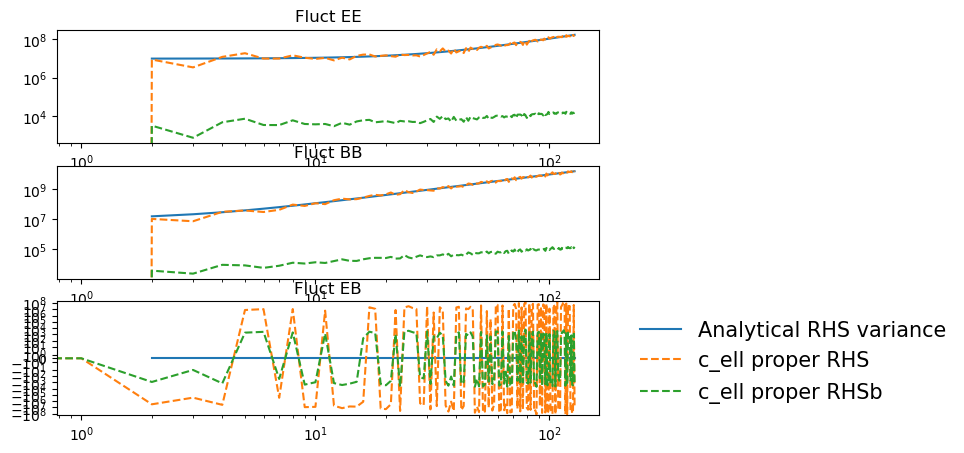

In [16]:
list_correl = ['EE', 'BB', 'EB']
indices_polar = np.array([1,2,4])

plt.figure(figsize=(7,5))
# plt.suptitle("Iter {} for mask {} with noise level {}".format(i, mask_name, noise_level), y=0.91)
plt.suptitle("")


# c_ells_output = hp.anafast(maps_iter, lmax=lmax, iter=n_iter)[indices_polar]
map_zeros = np.zeros_like(analytical_WF_0[0])

ell_arange = np.arange(c_ells_analytical_fluct_0b.shape[1])
for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title('Fluct '+list_correl[j])

    # plt.plot(ell_arange, c_ells_total.T[:,indices_polar[j]], label='Input')
    plt.plot(ell_arange[lmin:], true_inv_fluctuation_variance[j], label='Analytical RHS variance')
    plt.plot(ell_arange, c_ell_proper_RHS[j], '--', label='c_ell proper RHS')
    plt.plot(ell_arange, c_ell_proper_RHS_b[j], '--', label='c_ell proper RHSb')
    

    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')

    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


plt.show()

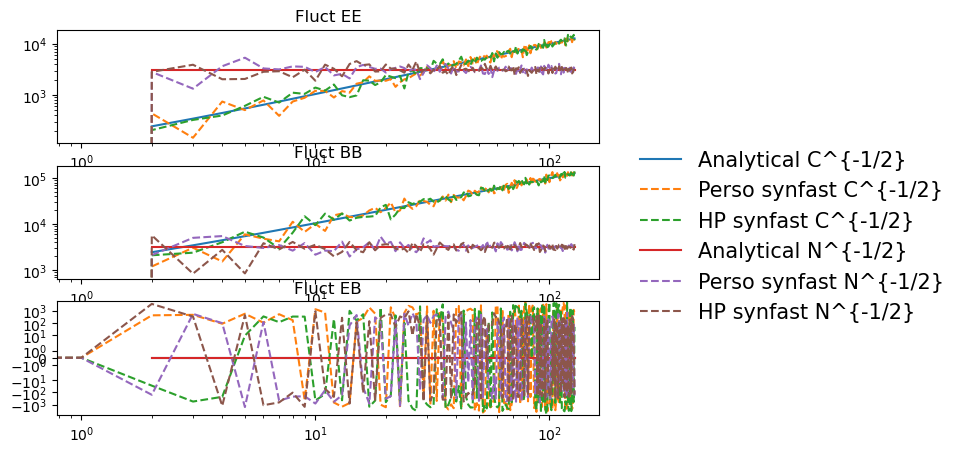

In [27]:
list_correl = ['EE', 'BB', 'EB']
indices_polar = np.array([1,2,4])

plt.figure(figsize=(7,5))
# plt.suptitle("Iter {} for mask {} with noise level {}".format(i, mask_name, noise_level), y=0.91)
plt.suptitle("")


# c_ells_output = hp.anafast(maps_iter, lmax=lmax, iter=n_iter)[indices_polar]
map_zeros = np.zeros_like(analytical_WF_0[0])

ell_arange = np.arange(c_ells_analytical_fluct_0b.shape[1])
for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title('Fluct '+list_correl[j])

    # plt.plot(ell_arange, c_ells_total.T[:,indices_polar[j]], label='Input')
    plt.plot(ell_arange[lmin:], c_ell_inv_cov_sqrt[j], label='Analytical C^{-1/2}')
    plt.plot(ell_arange, c_ell_fluctuation_1[j], '--', label='Perso synfast C^{-1/2}')
    plt.plot(ell_arange, c_ell_fluctuation_1_hp[j], '--', label='HP synfast C^{-1/2}')

    plt.plot(ell_arange[lmin:], c_ell_inv_noise_sqrt[j], label='Analytical N^{-1/2}')
    plt.plot(ell_arange, c_ell_fluctuation_2[j], '--', label='Perso synfast N^{-1/2}')
    plt.plot(ell_arange, c_ell_fluctuation_2_hp[j], '--', label='HP synfast N^{-1/2}')
    

    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')

    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 2.5), loc="upper left", prop={'size': 15}, frameon=False)


plt.show()

In [18]:
int(np.where(2 >1, 3, 1))

3